In [280]:
import yfinance as yf
import pandas as pd
import numpy as np
import talib
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import datetime
import matplotlib.pyplot as plt
import seaborn as sns


In [316]:
def get_data():
    # Download S&P 500 (GSPC) and VIX data
    start = '2010-01-01'
    end = datetime.datetime.today().strftime('%Y-%m-%d')
    # end = '2020-01-01' 
    sp500 = yf.download('^GSPC', start=start, end=datetime.datetime.today().strftime('%Y-%m-%d'))
    vix = yf.download('^VIX', start=start, end=datetime.datetime.today().strftime('%Y-%m-%d'))
    
    # Fetch 10-year Treasury Yield from FRED
    treasury_yield = yf.download("^TNX", start=start, end=datetime.datetime.today().strftime('%Y-%m-%d'))
    
    # Merge dataframes
    df = sp500[['Open', 'High', 'Low', 'Close', 'Volume']]
    df['VIX'] = vix['Close']
    df['10Y_Treasury'] = treasury_yield['Close']
    
    return df

In [317]:
def add_technical_indicators(df):
    df['Return'] = df['Close'].pct_change()
    df['VIX_CHANGE'] = df['VIX'].pct_change()
    df['10Y_CHANGE'] = df['10Y_Treasury'].pct_change()
    df['SMA_5'] = talib.SMA(df['Return'].values.flatten(), timeperiod=5)
    df['SMA_10'] = talib.SMA(df['Return'].values.flatten(), timeperiod=10)
    df['SMA_50'] = talib.SMA(df['Return'].values.flatten(), timeperiod=50)
    df['RSI'] = talib.RSI(df['Return'].values.flatten(), timeperiod=14)
    df['MACD'], df['MACD_signal'], _ = talib.MACD(df['Close'].values.flatten())
    df['MACD_zscore'] = (df['MACD'] - df['MACD'].mean()) / df['MACD'].std()
    df['ATR'] = talib.ATR(df['High'].values.flatten(), df['Low'].values.flatten(), df['Close'].values.flatten(), timeperiod=14)
    
    return df

In [318]:
def prepare_dataset(df):
    df['Target'] = np.where(df['Return'].shift(-1) > 0, 1, 0)  # Predicting if next day is up (1) or down (0)
    
    # Drop NaNs
    df.dropna(inplace=True)
    
    # Select features
    features = ['SMA_5','SMA_10', 'RSI', 'ATR', 'VIX_CHANGE', '10Y_CHANGE', 'Return']
    X = df[features]
    y = df['Target']
    
    return X, y

In [319]:
def train_and_evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    # Define models
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(),
        "Gradient Boosting (XGBoost)": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
        "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
    }

    best_model = None
    best_accuracy = 0

    # Train and evaluate each model
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy:.4f}")
        predict_next_day(model, X)
        
        if accuracy > best_accuracy:
            best_model = model
            best_accuracy = accuracy

    return models

In [320]:
def train_model(X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(),
        "Gradient Boosting (XGBoost)": GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, random_state=42),
        "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
    }

    for name, model in models.items():
        accuracies = []
        print(f"\nTraining {name} with Time-Series Cross Validation...")
        
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            accuracies.append(acc)
        
        avg_accuracy = np.mean(accuracies)
        print(accuracies)
        print(f"{name} Average Accuracy: {avg_accuracy:.4f}")
        predict_next_day(model, X)

In [321]:
def predict_next_day(model, X):
    latest_data = X.iloc[-1:].values.reshape(1, -1)
    prediction = model.predict(latest_data)
    
    if prediction[0] == 1:
        print("Prediction: S&P 500 will go UP tomorrow.")
    else:
        print("Prediction: S&P 500 will go DOWN tomorrow.")


In [322]:
print("Downloading data...")
df = get_data()
    
print("Adding technical indicators...")
df = add_technical_indicators(df)
    
print("Preparing dataset...")
X, y = prepare_dataset(df)
    
print("Training model...")
train_model(X, y)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Adding technical indicators...



<ipython-input-316-961f66fbbe79>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['VIX'] = vix['Close']
<ipython-input-316-961f66fbbe79>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['10Y_Treasury'] = treasury_yield['Close']
<ipython-input-317-5b9d0be61ead>:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA valu

Preparing dataset...
Training model...

Training Random Forest with Time-Series Cross Validation...
[0.5063897763578274, 0.5191693290734825, 0.5543130990415336, 0.5015974440894568, 0.5159744408945687]
Random Forest Average Accuracy: 0.5195
Prediction: S&P 500 will go DOWN tomorrow.

Training Logistic Regression with Time-Series Cross Validation...
[0.5575079872204473, 0.512779552715655, 0.5734824281150159, 0.5415335463258786, 0.5255591054313099]
Logistic Regression Average Accuracy: 0.5422
Prediction: S&P 500 will go UP tomorrow.

Training Gradient Boosting (XGBoost) with Time-Series Cross Validation...
[0.5463258785942492, 0.5079872204472844, 0.5543130990415336, 0.547923322683706, 0.5159744408945687]
Gradient Boosting (XGBoost) Average Accuracy: 0.5345
Prediction: S&P 500 will go UP tomorrow.

Training Neural Network (MLP) with Time-Series Cross Validation...
[0.5575079872204473, 0.5143769968051118, 0.5654952076677316, 0.5047923322683706, 0.5111821086261981]
Neural Network (MLP) Avera

<AxesSubplot:xlabel='Price-Ticker', ylabel='Price-Ticker'>

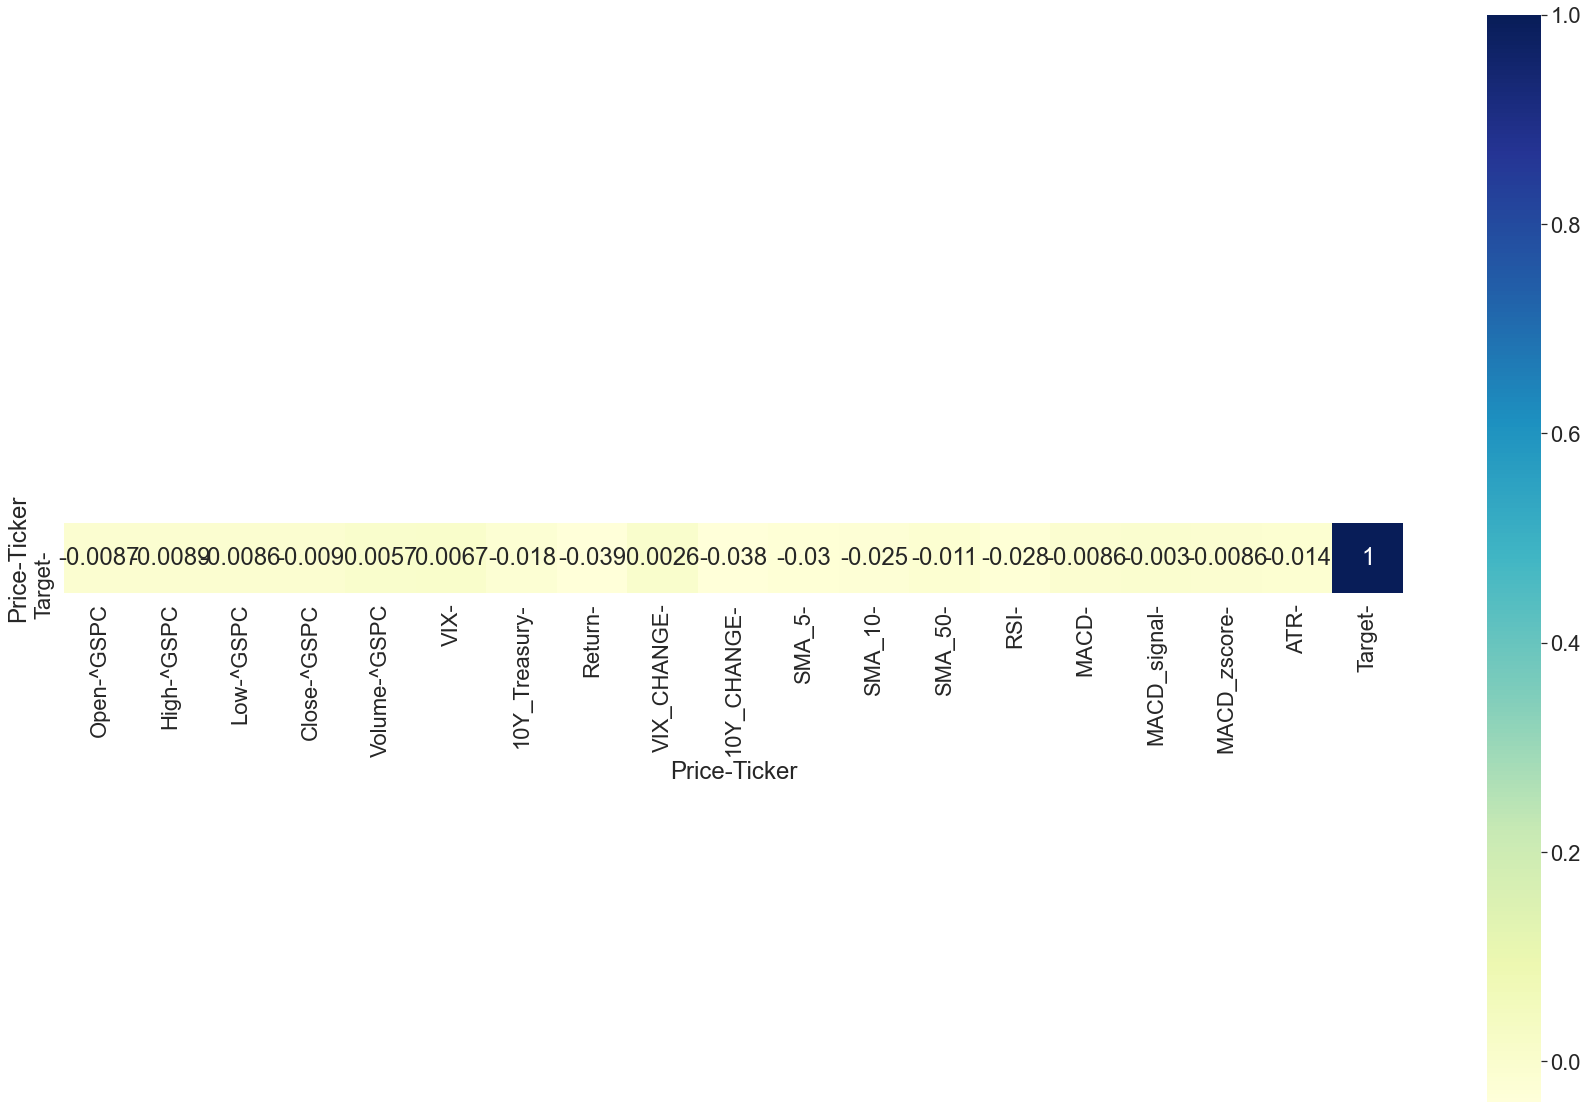

In [230]:
corr_mat = df.corr(method='pearson')
plt.figure(figsize=(30,20))
sns.set(font_scale=2)
sns.heatmap(corr_mat[['Target']].transpose(), vmax=1, square=True, annot=True, cmap="YlGnBu")

In [231]:
X_train

Price,SMA_5,SMA_10,RSI,ATR,VIX_CHANGE,10Y_CHANGE,Return
Ticker,,,,,,,
Date,,,,,,,
2013-07-24,0.000603,0.002009,47.014364,14.394337,0.041074,0.028617,-0.003811
2017-07-27,0.000160,0.001124,48.457436,13.560820,0.053125,0.012270,-0.000973
2018-06-25,-0.004104,-0.002347,43.285312,24.099567,0.258533,-0.008621,-0.013725
2018-07-03,-0.000709,-0.001784,47.908411,25.986479,0.034615,-0.009770,-0.004947
2018-02-08,-0.017457,-0.009323,40.866202,42.218087,0.206635,0.002461,-0.037536
...,...,...,...,...,...,...,...
2022-05-19,-0.001227,-0.005915,49.802809,103.469170,-0.052003,-0.010741,-0.005834
2019-01-03,-0.001535,-0.003695,45.335974,61.299013,0.096038,-0.040210,-0.024757


In [146]:
X_test

Price,SMA_10,RSI,ATR,MACD,MACD_signal,VIX,10Y_Treasury,Return
Ticker,,,,,,,,
Date,,,,,,,,
2012-10-12,-0.000831,48.443107,12.351100,2.618780,6.988144,16.139999,1.663,-0.002966
2017-08-22,-0.000877,55.813281,16.536232,-3.654294,0.940586,11.350000,2.215,0.009941
2006-05-19,-0.004498,53.039613,12.253203,-7.295698,-0.982662,17.180000,5.054,0.004137
2006-12-21,0.000785,46.607284,9.744392,9.771425,9.994409,10.530000,4.549,-0.003674
2010-04-01,0.001059,53.186254,11.130847,14.833279,15.199883,17.469999,3.859,0.007414
...,...,...,...,...,...,...,...,...
2009-02-06,0.004520,53.564193,27.406599,-8.771299,-11.692123,43.369999,2.979,0.026896
2021-09-13,-0.000899,51.683730,32.922141,20.840928,29.853239,19.370001,1.324,0.002276


In [147]:
y_test

Date
2012-10-12    1
2017-08-22    0
2006-05-19    0
2006-12-21    0
2010-04-01    1
             ..
2009-02-06    1
2021-09-13    0
2000-08-15    0
2016-06-08    0
2019-11-12    1
Name: Target, Length: 1255, dtype: int64

In [154]:
sum(y_pred) / len(y_pred)

0.6

In [155]:
y_pred[-10:]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 1])